In [1]:
import pandas as pd
import numpy as np
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
import multiprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from gensim.parsing.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

jdDataSet = pd.read_excel('jd_dataset_new.xlsx')
jdDataSet['cleaned_jd'] = ''
jdDataSet.head()

[nltk_data] Error loading wordnet: <urlopen error [Errno 2] No such
[nltk_data]     file or directory>
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,title,description,skills,cleaned_jd
0,ux designer,Our client is seeking a UI/UX Designer. Loca...,"CSS, Development, HTML, HTTP, JavaScript, Mana...",
1,ux designer,Position Description:Wipro Digital is seeking ...,UX Designing,
2,ux designer,HIGreetings from Data inc!!! Hope you are doin...,"""ui designer"" , ""user interface designer"" , ""v...",
3,ux designer,Our team is looking for an experienced UI/UX D...,"HTML 5, CSS3, jQuery, php, bootstrap, Angular",
4,ux designer,"Hi, Please send me your updated resume on raje...",UX Designer,


In [2]:
def clean(text):
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('[%s]' % re.escape("""!"$%&'()*,-/:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text

In [3]:
def extractNoun(wordsList):
    tagged = nltk.pos_tag(wordsList)
    filtered_pos = []
    for one in tagged:
        if one[1] == 'NN' or one[1] == 'NNS' or one[1] == 'NNP' or one[1] == 'NNPS':
            filtered_pos.append(one[0])
    return filtered_pos

In [4]:
#cleaning data
jdDataSet['cleaned_jd'] = jdDataSet.description.apply(lambda x: clean(x))

# Removing the stop words
jdDataSet['cleaned_jd'] = jdDataSet.cleaned_jd.apply(lambda x: remove_stopwords(x))

# Tokenize the text column
jdDataSet['cleaned_jd'] = [simple_preprocess(line, deacc=True) for line in jdDataSet['cleaned_jd']] 

# Get the stemmed_tokens
porter_stemmer = PorterStemmer()
jdDataSet['cleaned_jd'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in jdDataSet['cleaned_jd'] ]

# get the lammatized tokens
lemmatizer = WordNetLemmatizer() 
jdDataSet['cleaned_jd'] = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in jdDataSet['cleaned_jd'] ]

# extract only noun 
jdDataSet['cleaned_jd'] = jdDataSet.cleaned_jd.apply(lambda x: extractNoun(x))

jdDataSet['cleaned_jd']

0       [client, seek, design, locat, bethesda, md, po...
1       [posit, descript, digit, seek, design, deliv, ...
2       [higreet, data, financi, client, design, role,...
3       [team, look, design, basi, resid, francisco, b...
4       [hi, plea, resum, interest, posit, design, loc...
                              ...                        
2495    [plea, email, resum, shveta, lead, sr, data, e...
2496            [need, data, expertis, sql, python, hive]
2497    [bach, degre, posit, plea, resum, word, format...
2498    [titl, data, boston, madur, competit, doe, can...
2499    [data, engineerjob, data, support, quantit, en...
Name: cleaned_jd, Length: 2500, dtype: object

In [5]:
# to do classification only skilss
def extractSkills(string):
    if isinstance(string,float):
        return [" "," "]
    lst = string.split(',')
    lst = [s.strip() for s in lst]
    lst = [skill.lower() for skill in lst]
    return lst

jdDataSet['cleaned_jd'] += jdDataSet.skills.apply(lambda x: list(extractSkills(x)) + list(extractSkills(x)))

jdDataSet['cleaned_jd']

0       [client, seek, design, locat, bethesda, md, po...
1       [posit, descript, digit, seek, design, deliv, ...
2       [higreet, data, financi, client, design, role,...
3       [team, look, design, basi, resid, francisco, b...
4       [hi, plea, resum, interest, posit, design, loc...
                              ...                        
2495    [plea, email, resum, shveta, lead, sr, data, e...
2496    [need, data, expertis, sql, python, hive, sql,...
2497    [bach, degre, posit, plea, resum, word, format...
2498    [titl, data, boston, madur, competit, doe, can...
2499    [data, engineerjob, data, support, quantit, en...
Name: cleaned_jd, Length: 2500, dtype: object

In [6]:
train, test = train_test_split(jdDataSet, test_size=0.3, random_state=40)

train_tagged = train.apply( lambda r: TaggedDocument(words=r['cleaned_jd'], tags=[r.title]), axis=1)
test_tagged = test.apply( lambda r: TaggedDocument(words=r['cleaned_jd'], tags=[r.title]), axis=1)

In [7]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words,alpha=0.065)) for doc in sents])
    return targets, regressors

In [8]:
# from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
class ConcatenatedDocvecs(object):
    def __init__(self, models):
        self.models = models

    def __getitem__(self, token):
        return np.concatenate([model[token] for model in self.models])

class ConcatenatedDoc2Vec(object):
    """
    Concatenation of multiple models for reproducing the Paragraph Vectors paper.
    Models must have exactly-matching vocabulary and document IDs. (Models should
    be trained separately; this wrapper just returns concatenated results.)
    """

    def __init__(self, models):
        self.models = models
        if hasattr(models[0], 'docvecs'):
            self.docvecs = ConcatenatedDocvecs([model.docvecs for model in models])

    def __getitem__(self, token):
        return np.concatenate([model[token] for model in self.models])

    def infer_vector(self, document, alpha=0.065, min_alpha=0.065, steps=20):
        return np.concatenate([model.infer_vector(document, alpha, min_alpha, steps) for model in self.models])

    def train(self, *ignore_args, **ignore_kwargs):
        pass  # train subcomponents individually

In [23]:
def model_accuracy(vector_sz=325,window_sz=15,Epochs_Num=25):
    model_dbow = Doc2Vec(dm=0, vector_size=vector_sz, negative=5, window=window_sz, min_count=2, workers=5,alpha=0.065, min_alpha=0.065)
    model_dbow.build_vocab(train_tagged.values)
    for epoch in range(Epochs_Num):
        model_dbow.train(utils.shuffle(train_tagged.values), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha

    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=vector_sz, negative=5, window=window_sz, min_count=2, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab(train_tagged.values)
    for epoch in range(Epochs_Num):
        model_dmm.train(utils.shuffle(train_tagged.values), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha

    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)

    logreg = LogisticRegression(n_jobs=1, C=1e10,max_iter=30000)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    return [accuracy_score(y_test, y_pred),f1_score(y_test, y_pred, average='weighted')]

In [14]:
vc_size_x = []
accuracy_y = []
f1_score_y = []

for vc_sz in range(25,401,25):
    vc_size_x.append(vc_sz)
    list = model_accuracy(vector_sz=vc_sz)
    accuracy_y.append(list[0])
    f1_score_y.append(list[1])

C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if hasattr(models[0], 'docvecs'):
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:19: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  self.docvecs = ConcatenatedDocvecs([model.docvecs for model in models])
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if hasattr(models[0], 'docvecs'):
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:19: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  self.docvecs = ConcatenatedDocvecs([model.docvecs for model in models])
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `doc

In [15]:
for i in range(len(vc_size_x)):
    print(vc_size_x[i], accuracy_y[i], f1_score_y[i])
    accuracy_y[i] = accuracy_y[i] * 100
    f1_score_y[i] = f1_score_y[i] * 100

25 0.672 0.6639970171289618
50 0.6906666666666667 0.6766193235601211
75 0.692 0.6793252119056677
100 0.7106666666666667 0.7014710715505653
125 0.724 0.7071141374760451
150 0.716 0.704207763681647
175 0.7293333333333333 0.713670134139805
200 0.7306666666666667 0.7181896017420971
225 0.7346666666666667 0.7236990376900606
250 0.736 0.7249111154199513
275 0.7266666666666667 0.7124947034632119
300 0.712 0.7025409602482129
325 0.7386666666666667 0.724630256848024
350 0.7306666666666667 0.7191500586567646
375 0.7293333333333333 0.7147801869487742
400 0.7293333333333333 0.7142707395769324


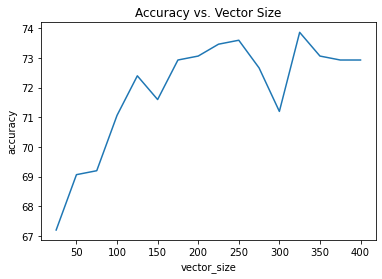

In [16]:
# vc_size_x = []
# accuracy_y = []
# f1_score_y = []

# plotting the points
plt.plot(vc_size_x, accuracy_y)

# naming the x axis
plt.xlabel('vector_size')
# naming the y axis
plt.ylabel('accuracy')
 
# giving a title to my graph
plt.title('Accuracy vs. Vector Size')
 
# function to show the plot
plt.show()

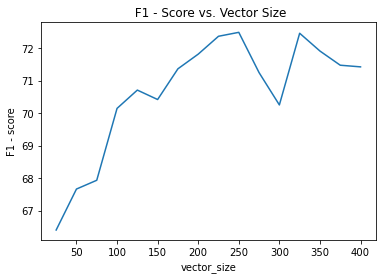

In [17]:
# plotting the points
plt.plot(vc_size_x, f1_score_y)
 
# naming the x axis
plt.xlabel('vector_size')
# naming the y axis
plt.ylabel('F1 - score')
 
# giving a title to my graph
plt.title(' F1 - Score vs. Vector Size')
 
# function to show the plot
plt.show()

In [19]:
window_size_x = []
accuracy_y = []
f1_score_y = []

for window in range(5,41,5):
    window_size_x.append(window)
    list = model_accuracy(window_sz=window)
    accuracy_y.append(list[0])
    f1_score_y.append(list[1])

C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if hasattr(models[0], 'docvecs'):
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:19: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  self.docvecs = ConcatenatedDocvecs([model.docvecs for model in models])
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if hasattr(models[0], 'docvecs'):
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:19: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  self.docvecs = ConcatenatedDocvecs([model.docvecs for model in models])
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `doc

In [20]:
for i in range(len(window_size_x)):
    print(window_size_x[i], accuracy_y[i], f1_score_y[i])
    accuracy_y[i] = accuracy_y[i] * 100
    f1_score_y[i] = f1_score_y[i] * 100

5 0.732 0.7238863670322371
10 0.736 0.7263224602354287
15 0.7373333333333333 0.7254429406783036
20 0.7266666666666667 0.711895667386883
25 0.7146666666666667 0.6980505694792148
30 0.7253333333333334 0.7037671423424432
35 0.712 0.6986800944452249
40 0.716 0.6978713622837014


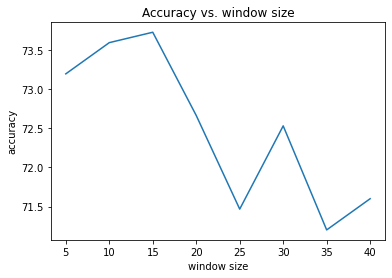

In [21]:
# window_size_x = []
# accuracy_y = []
# f1_score_y = []

# plotting the points
plt.plot(window_size_x, accuracy_y)

# naming the x axis
plt.xlabel('window size')
# naming the y axis
plt.ylabel('accuracy')
 
# giving a title to my graph
plt.title('Accuracy vs. window size')
 
# function to show the plot
plt.show()

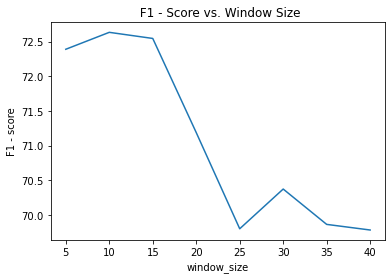

In [22]:
# plotting the points
plt.plot(window_size_x, f1_score_y)
 
# naming the x axis
plt.xlabel('window_size')
# naming the y axis
plt.ylabel('F1 - score')
 
# giving a title to my graph
plt.title(' F1 - Score vs. Window Size')
 
# function to show the plot
plt.show()

In [24]:
Epochs_x = []
accuracy_y = []
f1_score_y = []

for Epochs_number in range(5,51,5):
    Epochs_x.append(Epochs_number)
    list = model_accuracy(Epochs_Num=Epochs_number)
    accuracy_y.append(list[0])
    f1_score_y.append(list[1])

C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if hasattr(models[0], 'docvecs'):
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:19: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  self.docvecs = ConcatenatedDocvecs([model.docvecs for model in models])
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if hasattr(models[0], 'docvecs'):
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:19: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  self.docvecs = ConcatenatedDocvecs([model.docvecs for model in models])
C:\Users\DELL\AppData\Local\Temp/ipykernel_10308/261005283.py:18: DeprecationWarning: Call to deprecated `docvecs` (The `doc

In [25]:
for i in range(len(Epochs_x)):
    accuracy_y[i] = accuracy_y[i] * 100
    f1_score_y[i] = f1_score_y[i] * 100
    print(Epochs_x[i], accuracy_y[i], f1_score_y[i])

5 71.73333333333333 71.5237503507886
10 70.53333333333333 69.582830387518
15 71.2 70.4481204853502
20 71.86666666666667 70.37572196505153
25 73.86666666666667 72.71148036307059
30 73.33333333333333 71.94284100533795
35 69.86666666666666 69.51402410165403
40 67.33333333333333 67.0494991867571
45 66.93333333333334 66.18479504812369
50 66.8 66.16868200965239


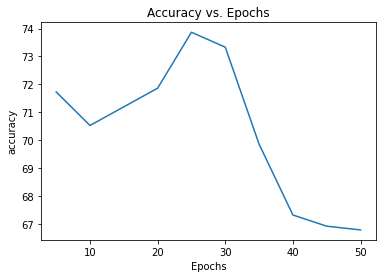

In [26]:
# Epochs_x = []
# accuracy_y = []
# f1_score_y = []

# plotting the points
plt.plot(Epochs_x, accuracy_y)

# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('accuracy')
 
# giving a title to my graph
plt.title('Accuracy vs. Epochs')

# function to show the plot
plt.show()

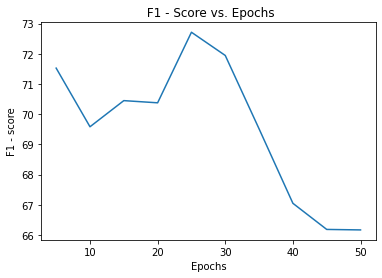

In [27]:
# plotting the points
plt.plot(Epochs_x, f1_score_y)
 
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('F1 - score')
 
# giving a title to my graph
plt.title(' F1 - Score vs. Epochs')
 
# function to show the plot
plt.show()